In [823]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import datestr2num
import matplotlib.animation as animation
import seaborn as sns
import datetime

In [824]:
def date_labeler(label, date, return_col, df, y_offset=0):
    x = datestr2num(date)
    y = df.loc[date][return_col].mean()
    y_lim = plt.gca().axes.get_ylim()[-1]
    
    return plt.annotate(label
                        , xy=(x, y)
                        , xytext=(x, y+(0.1 * y_lim)+(y_offset * y_lim))
                        , arrowprops=dict(arrowstyle="->", color="w")
                        , ha="center"
                        , backgroundcolor="black"
                        , fontsize=9
                        )

In [825]:
def style():
#     plt.rcParams.update(plt.rcParamsDefault)
    plt.figure(figsize=(9, 6), dpi=300)
    sns.set_style("whitegrid")
    plt.style.use("dark_background")
    plt.rc('font', weight='bold')
    plt.rcParams.update({
        "axes.labelsize": 18
        , "axes.labelweight": "1000"
        , "text.latex.preamble": r'\usepackage{sfmath} \boldmath'
        , "xtick.labelsize": 12
        , "ytick.labelsize": 12
        , "legend.fontsize": 12
        , "axes.linewidth": 0
        , "grid.color": "#666"
        , "patch.edgecolor": "None"
        , "scatter.edgecolors": "None"
        , "lines.markeredgecolor": "None"
        , "lines.linewidth": "3"
    })

In [826]:
# colors
colors = "#EF476F #FFD166 #06D6A0 #118AB2 #073B4C".split()

In [827]:
# orbit list
orbit_list = "LLEO LEO GEO MEO GTO".split()

In [828]:
# import
satcat = pd.read_csv("satcat.tsv", delimiter="\t")

# cleaning and adding info
satcat.replace("-", np.nan, inplace=True)
satcat.Mass = satcat.Mass.astype("float")
satcat.DryMass = satcat.DryMass.astype("float")
satcat.TotMass = satcat.TotMass.astype("float")
# satcat.loc[satcat.DryMass == 0, "DryMass"] = np.nan
satcat["Launch_Tag"] = satcat.Piece.str.extract(r"(^[0-9]{4}[- ].{3})")
satcat["Label"] = "Other"
satcat.loc[satcat.Name.str.contains("\(STS", na=False), "Label"] = "STS"
satcat.loc[satcat.Name.str.contains("Apollo", na=False), "Label"] = "Apollo"
satcat.loc[satcat.Name.str.startswith("OneWeb", na=False), "Label"] = "OneWeb"
satcat.loc[satcat.Name.str.startswith("Starlink", na=False), "Label"] = "Starlink"
satcat["SimpOrb"] = satcat.OpOrbit.str.extract("(\w*(?=\/)|\w*\Z)")

# remove entries without precise LDate and convert to datetime
satcat.drop(satcat.loc[satcat.LDate.str.contains("\?") == True].index, inplace=True)
satcat.LDate = pd.to_datetime(satcat.LDate)

# subsetting data
payloads = satcat[satcat.Type.str.startswith("P", na=False)]

pl_by_launch = payloads.groupby("Launch_Tag") \
    ["LDate JCAT Name State Label SimpOrb".split()].first()
pl_by_launch = pl_by_launch.merge(payloads.groupby("Launch_Tag") \
                                  .agg({"Mass": "sum", "DryMass": "sum", "TotMass": "sum"})
                   , on="Launch_Tag").reset_index()
pl_by_launch["TotLaunches"] = 1
pl_by_launch["TotLaunches"] = pl_by_launch.TotLaunches.cumsum()

launch_by_country = pl_by_launch.copy()
launch_by_country.State.replace(["SU", "RU"], "SU+RU", inplace=True)
launch_by_country.TotLaunches = 1
launch_by_country = launch_by_country.groupby(["State", "LDate"]).TotLaunches.sum() \
  .groupby(level=0).cumsum().reset_index()

/Users/ivenwinkelmann/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (1,18,20,22,24,26,28,32,36) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [829]:
# phone data from
# https://data.worldbank.org/indicator/IT.CEL.SETS via Gapminder
phones = pd.read_csv("cell_phones_total.csv")

# clean up phones for single purpose time series
replace_dict = {"[kK]": "*1e3", "[mM]": "*1e6", "[bB]": "*1e9"}
phones = phones.set_index("country").replace(replace_dict, regex=True) \
    .applymap(pd.eval, na_action="ignore").astype("float").T.interpolate().sum(axis=1)
phones.index = pd.to_datetime(phones.index, format="%Y")
phones = phones.to_frame()
phones.rename(columns={0: "phones_in_world"}, inplace=True)
phones = phones.loc["1980":]

In [830]:
# list of resuable launch vehicles and their capabilites
reusable_lv = pd.read_csv("reusable_lv.csv", sep=";")
reusable_lv.ToLEO = reusable_lv.ToLEO / 1_000

<Figure size 2700x1800 with 0 Axes>

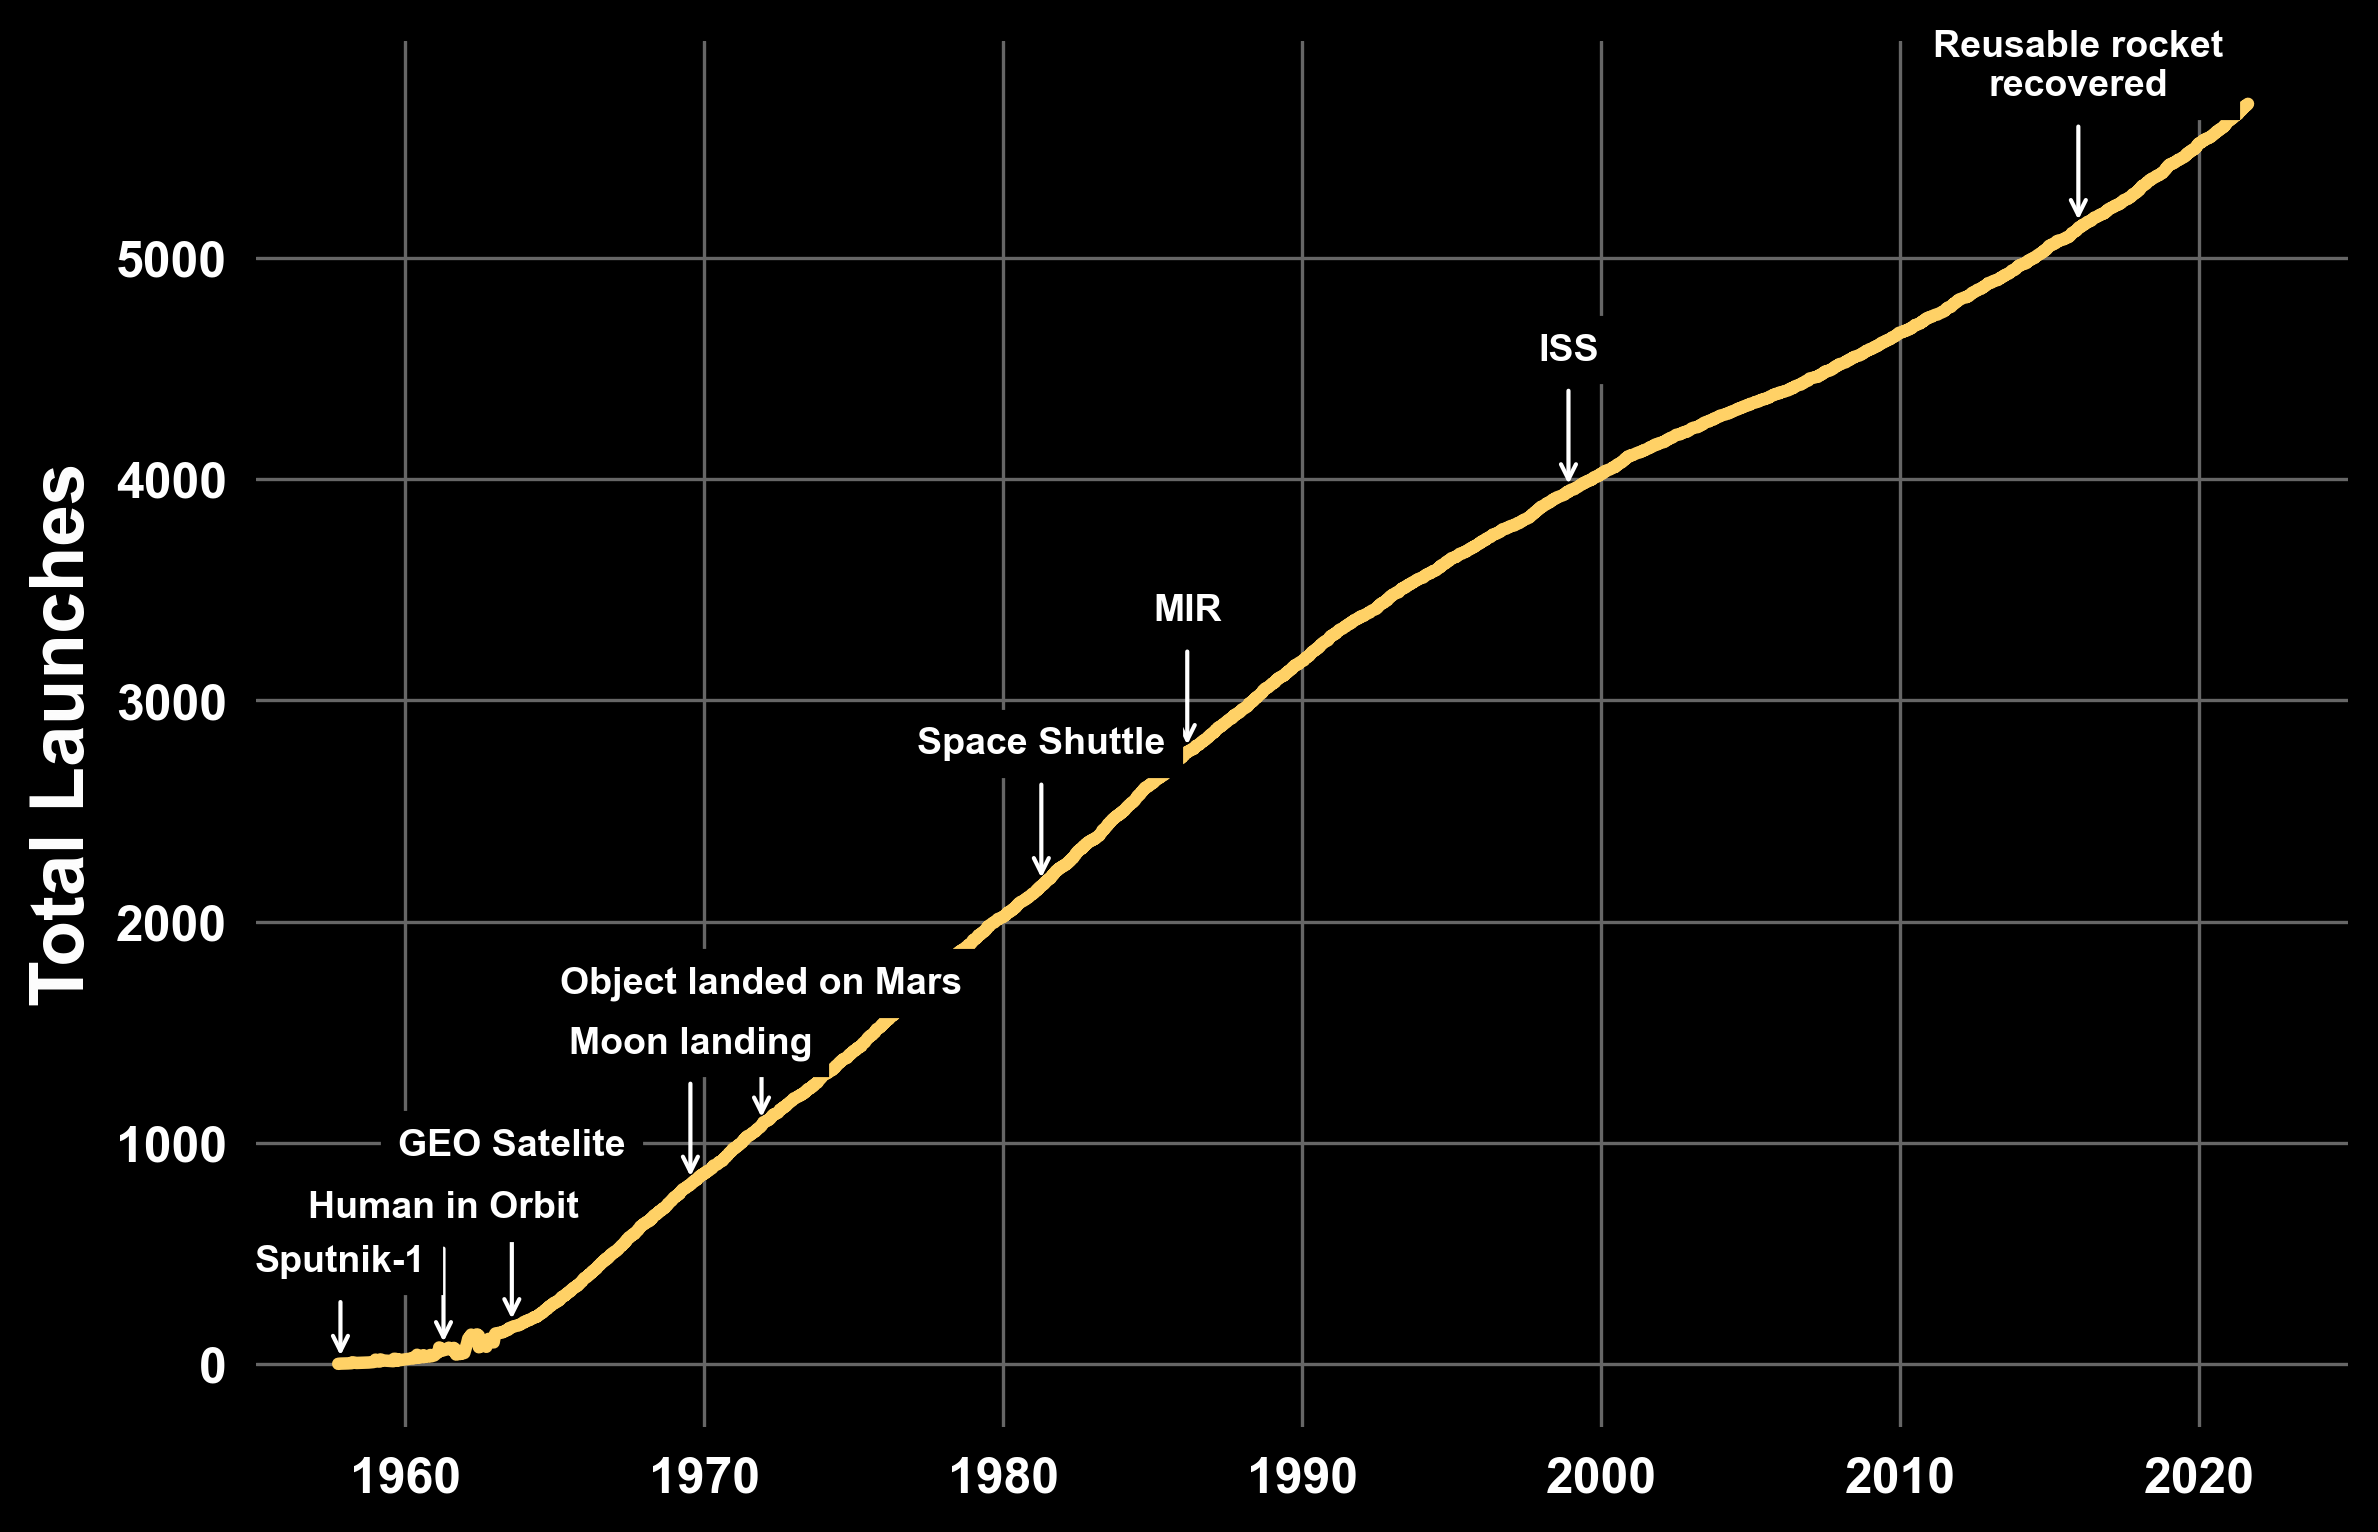

In [831]:
style()
plt.xlim(datetime.date(1955,1,1), datetime.date(2025,1,1))

sns.lineplot(
    data=pl_by_launch
    , x="LDate"
    , y="TotLaunches"
    , ci=None
    , color=colors[1]
)
                 
historic_dates = [
    ("Sputnik-1", "October 1957", -0.03)
    , ("Human in Orbit", "April 12, 1961", 0)
    , ("GEO Satelite", "July 26, 1963", 0.03)
    , ("Moon landing", "1969-07-16", 0)
    , ("Object landed on Mars", "Dec. 2, 1971", 0)
    #                  , ("Apollo 17", "December 7, 1972")
    , ("Space Shuttle", "April 12, 1981", 0)
    #                  , ("Last STS flight", "July 8, 2011")
    #                  , ("Challenger", "January 28, 1986")
    #                  , ("Columbia", "February, 2003")
    , ("MIR", "February 1986", 0)
    , ("ISS", "November 1998", 0)
    #                  , ("Buran", "15 November 1988")
    #                  , ("Fall of SU", "December, 1991")
    , ("Reusable rocket\nrecovered", "December 21, 2015", 0)
]

for event, date, y_off in historic_dates[::-1]:
    date_labeler(event, date, "TotLaunches", pl_by_launch.set_index("LDate"), y_off)
    
plt.xlabel("")
plt.ylabel("Total Launches")

plt.show()

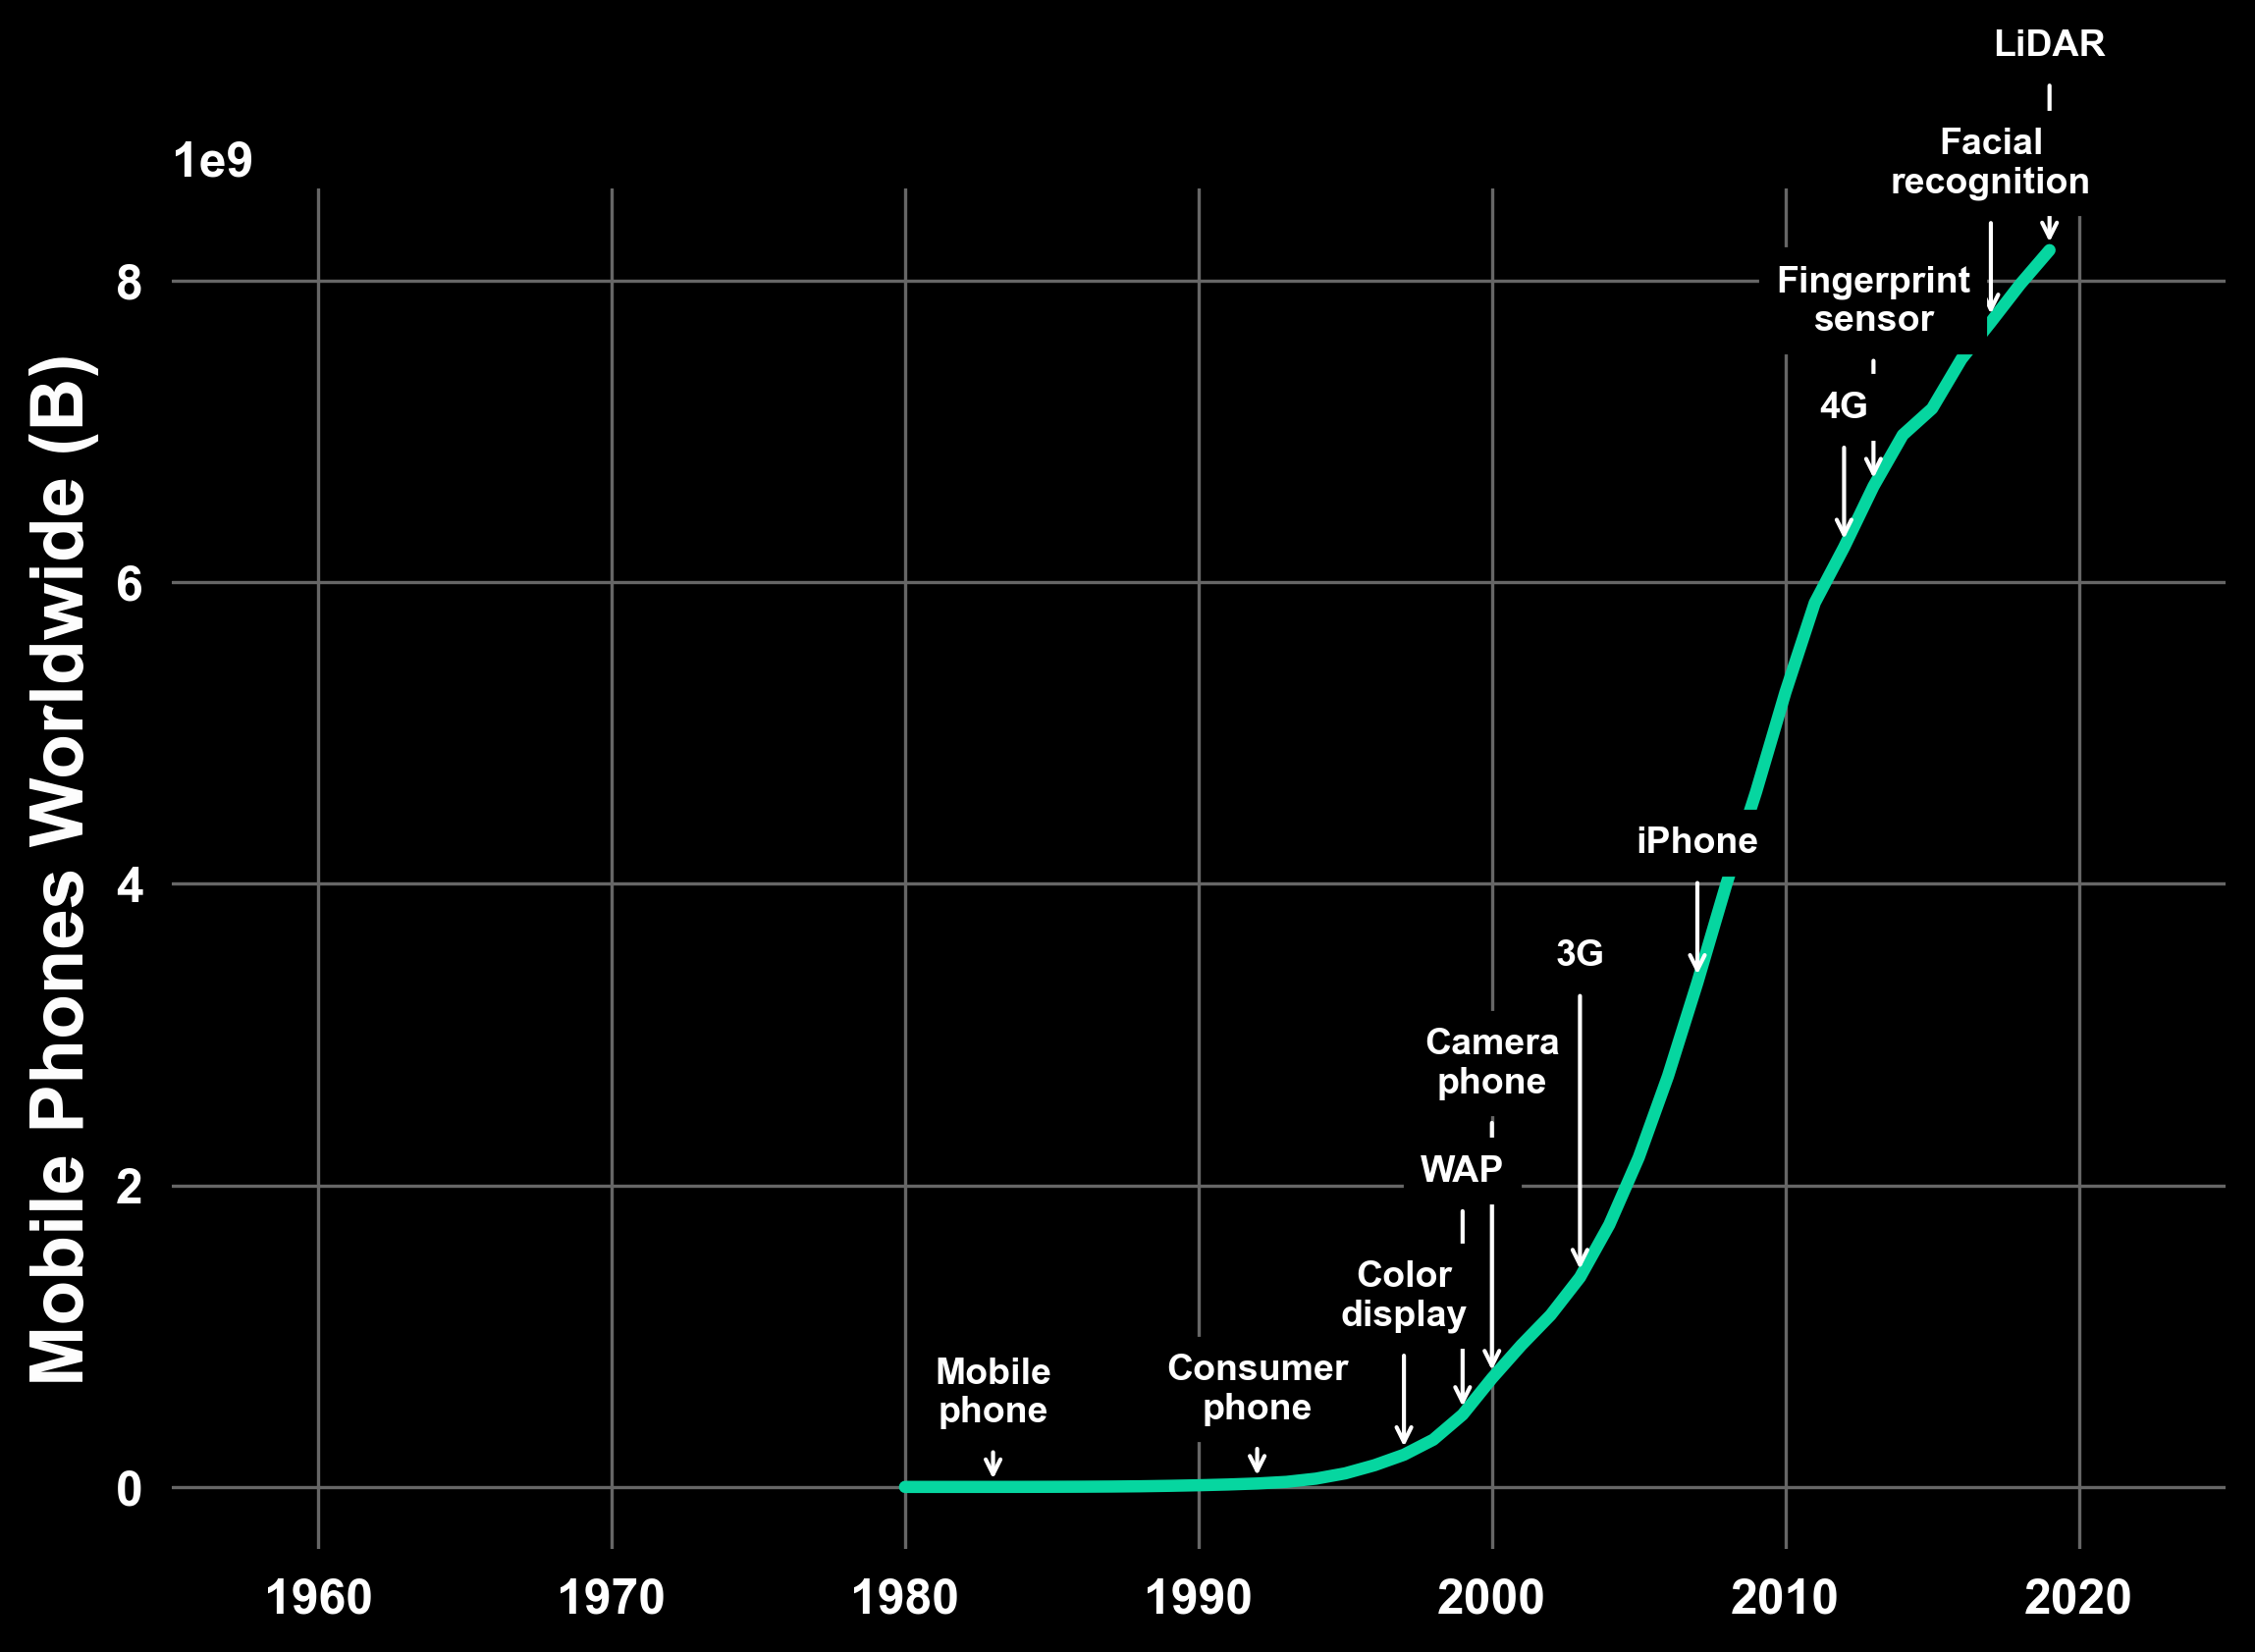

In [832]:
style()

plt.xlim(datetime.date(1955,1,1), datetime.date(2025,1,1))

g = sns.lineplot(
    data=phones
    , x=phones.index
    , y="phones_in_world"
    , ci=None
    , color=colors[2]
)

plt.ylabel("Mobile Phones Worldwide (B)")

historic_dates = [
    ("Mobile\nphone", "1983-01-01", -0.05)
    , ("Consumer\nphone", "1992-01-01", -0.05)
    , ("Color\ndisplay", "1997-01-01", 0)
    , ("WAP", "1999-01-01", 0.08)
    , ("Camera\nphone", "2000-01-01", 0.12)
    , ("3G", "2003-01-01", 0.14)
    , ("iPhone", "2007-01-01", 0)
    , ("4G", "2012-01-01", 0)
    , ("Fingerprint\nsensor", "2013-01-01", 0.02)
    , ("Facial\nrecognition", "2017-01-01", 0)
    , ("LiDAR", "2019-01-01", 0.05)
]

for event, date, y_off in historic_dates[::-1]:
    date_labeler(event, date, "phones_in_world", phones, y_off)

plt.show()

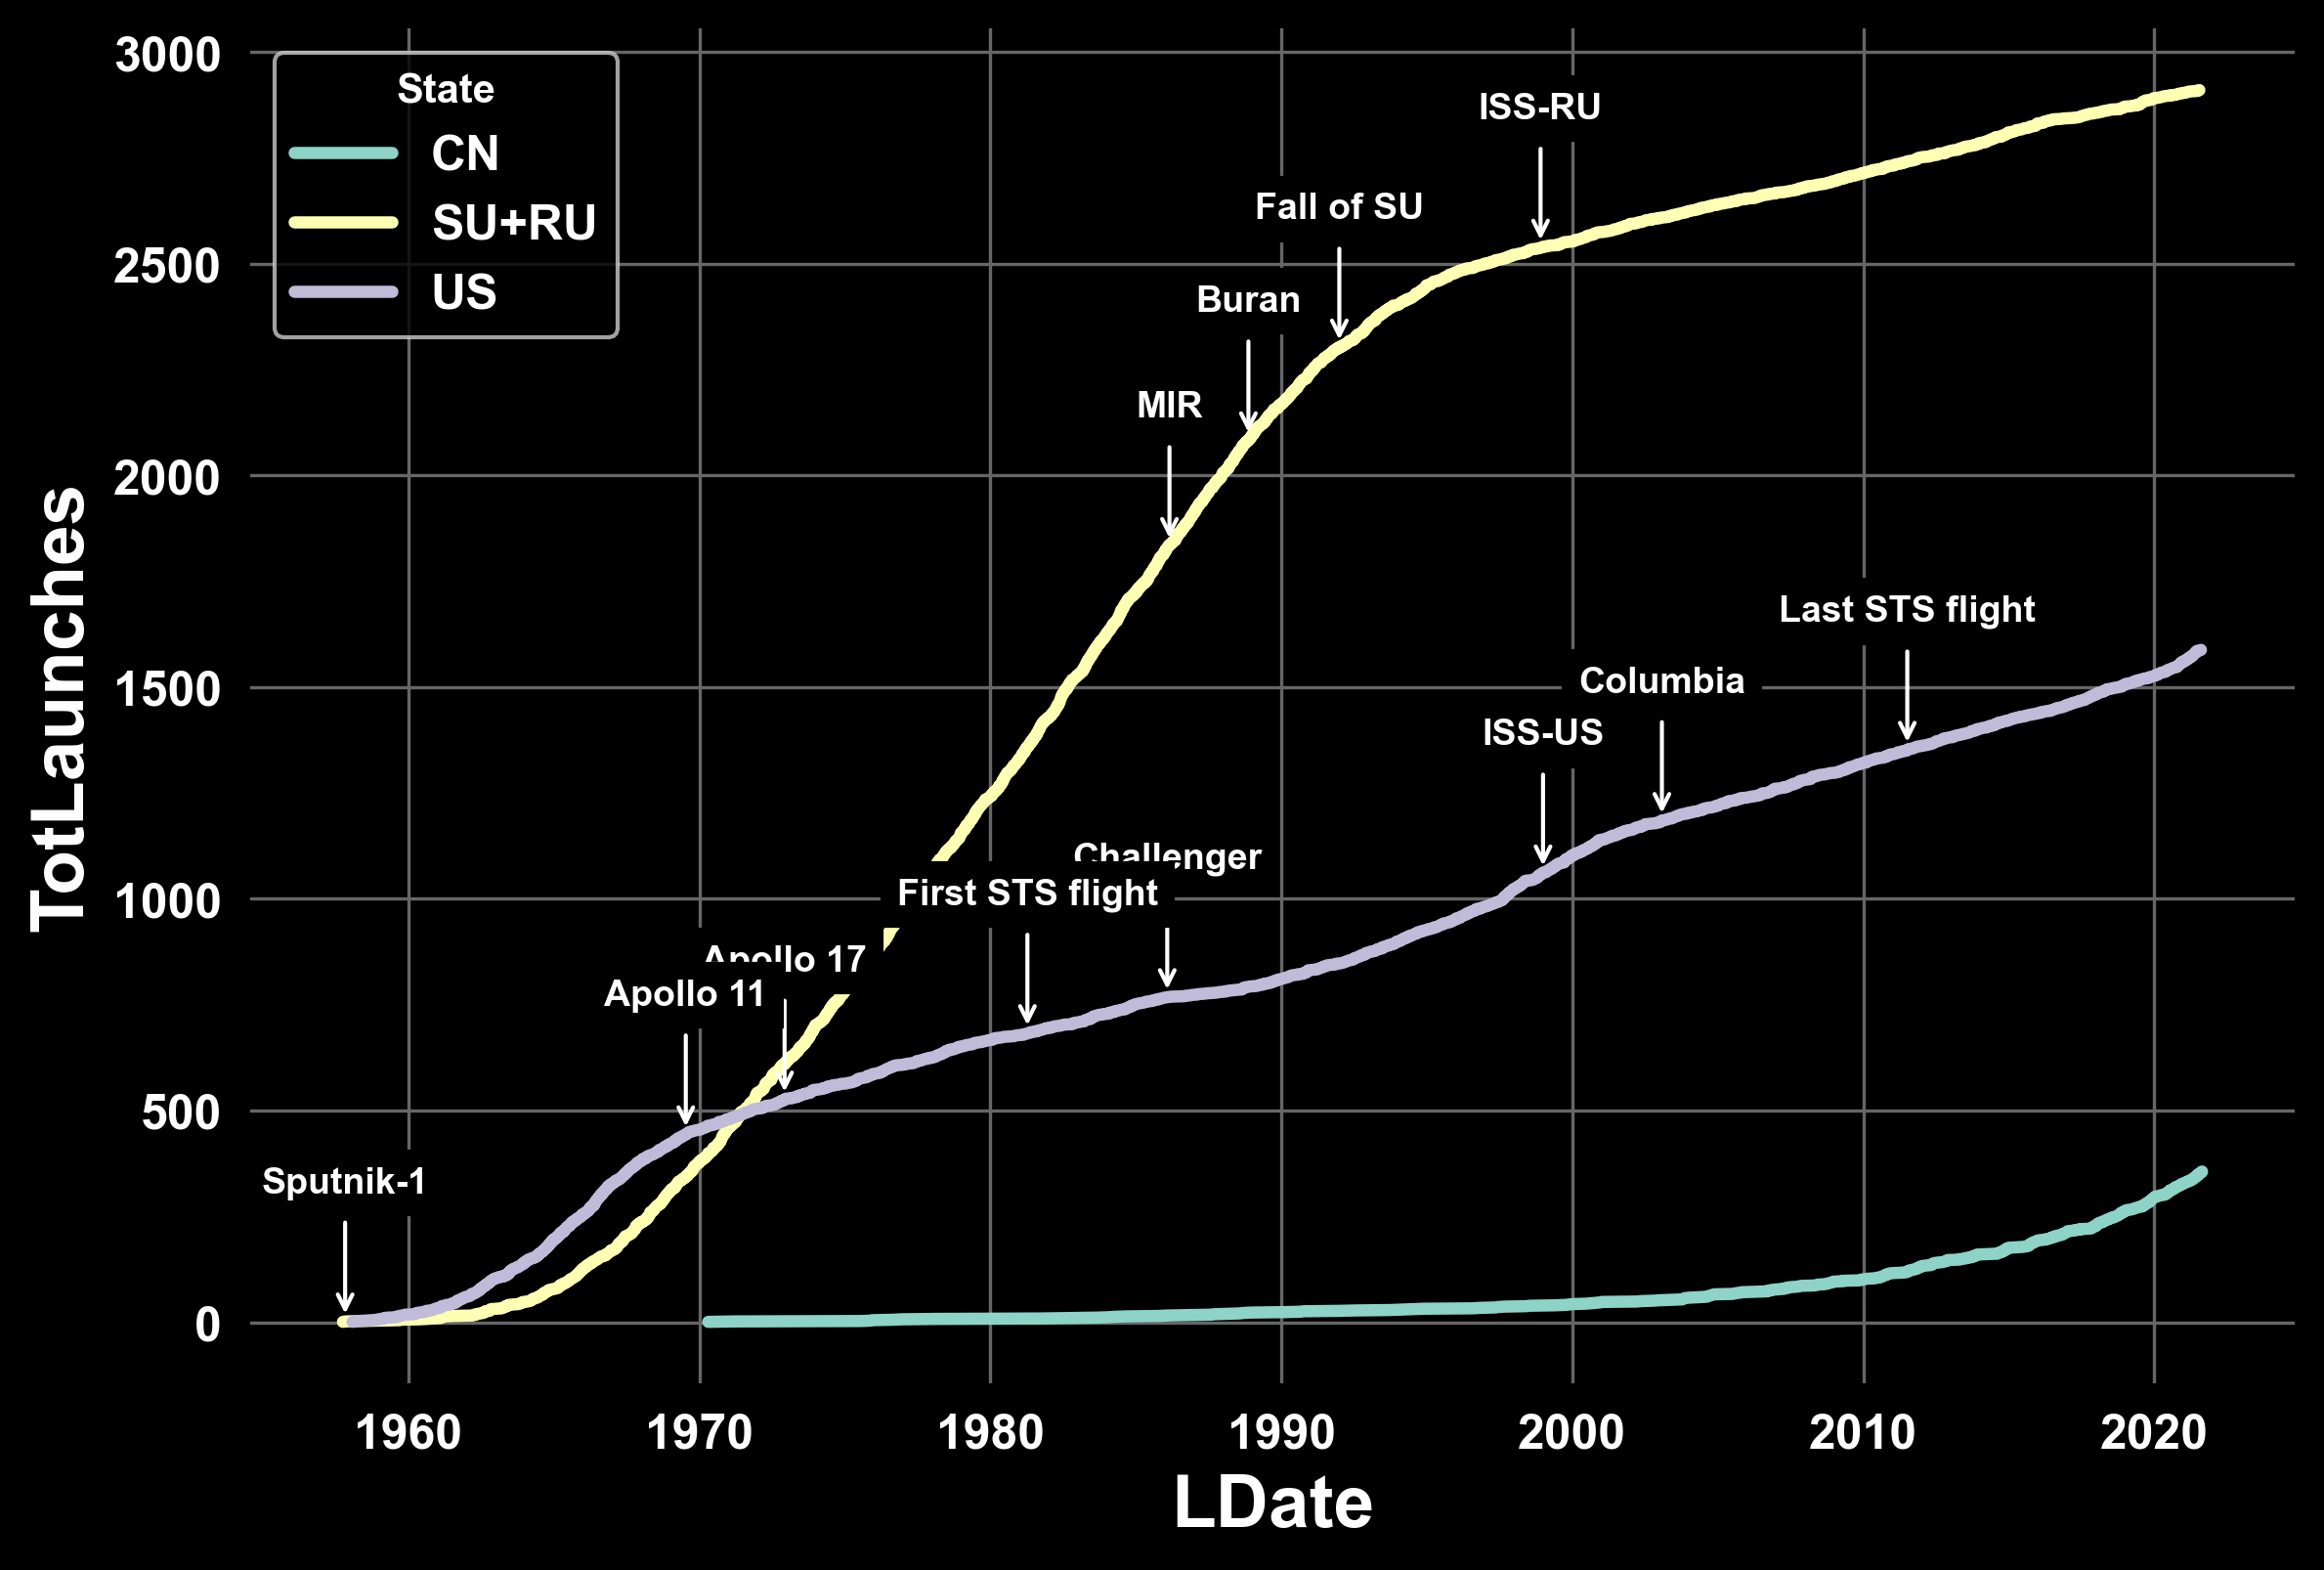

In [833]:
style()

countries = "US SU+RU CN".split()
# countries = "US".split()
data = launch_by_country[launch_by_country.State.isin(countries)]

g = sns.lineplot(data=data
                , x="LDate"
                , y="TotLaunches"
                , hue="State"
                , ci=None)

historic_dates = [("Apollo 11", "1969-07-16")
                 , ("Apollo 17", "December 7, 1972")
                 , ("First STS flight", "April 12, 1981")
                 , ("Last STS flight", "July 8, 2011")
                 , ("Challenger", "January, 1986")
                 , ("Columbia", "January, 2003")
                 , ("ISS-US", "December 1998")]

for event, date in historic_dates[::-1]:
    date_labeler(event, date, "TotLaunches", data[data.State == "US"].set_index("LDate"))
    
historic_dates = [("Sputnik-1", "October 1957")
                 , ("MIR", "February 1986")
                 , ("ISS-RU", "November 1998")
                 , ("Buran", "15 November 1988")
                 , ("Fall of SU", "December, 1991")]
    
for event, date in historic_dates[::-1]:
    date_labeler(event, date, "TotLaunches", data[data.State == "SU+RU"].set_index("LDate"))

plt.show()

In [834]:
avg

1406.653379170057

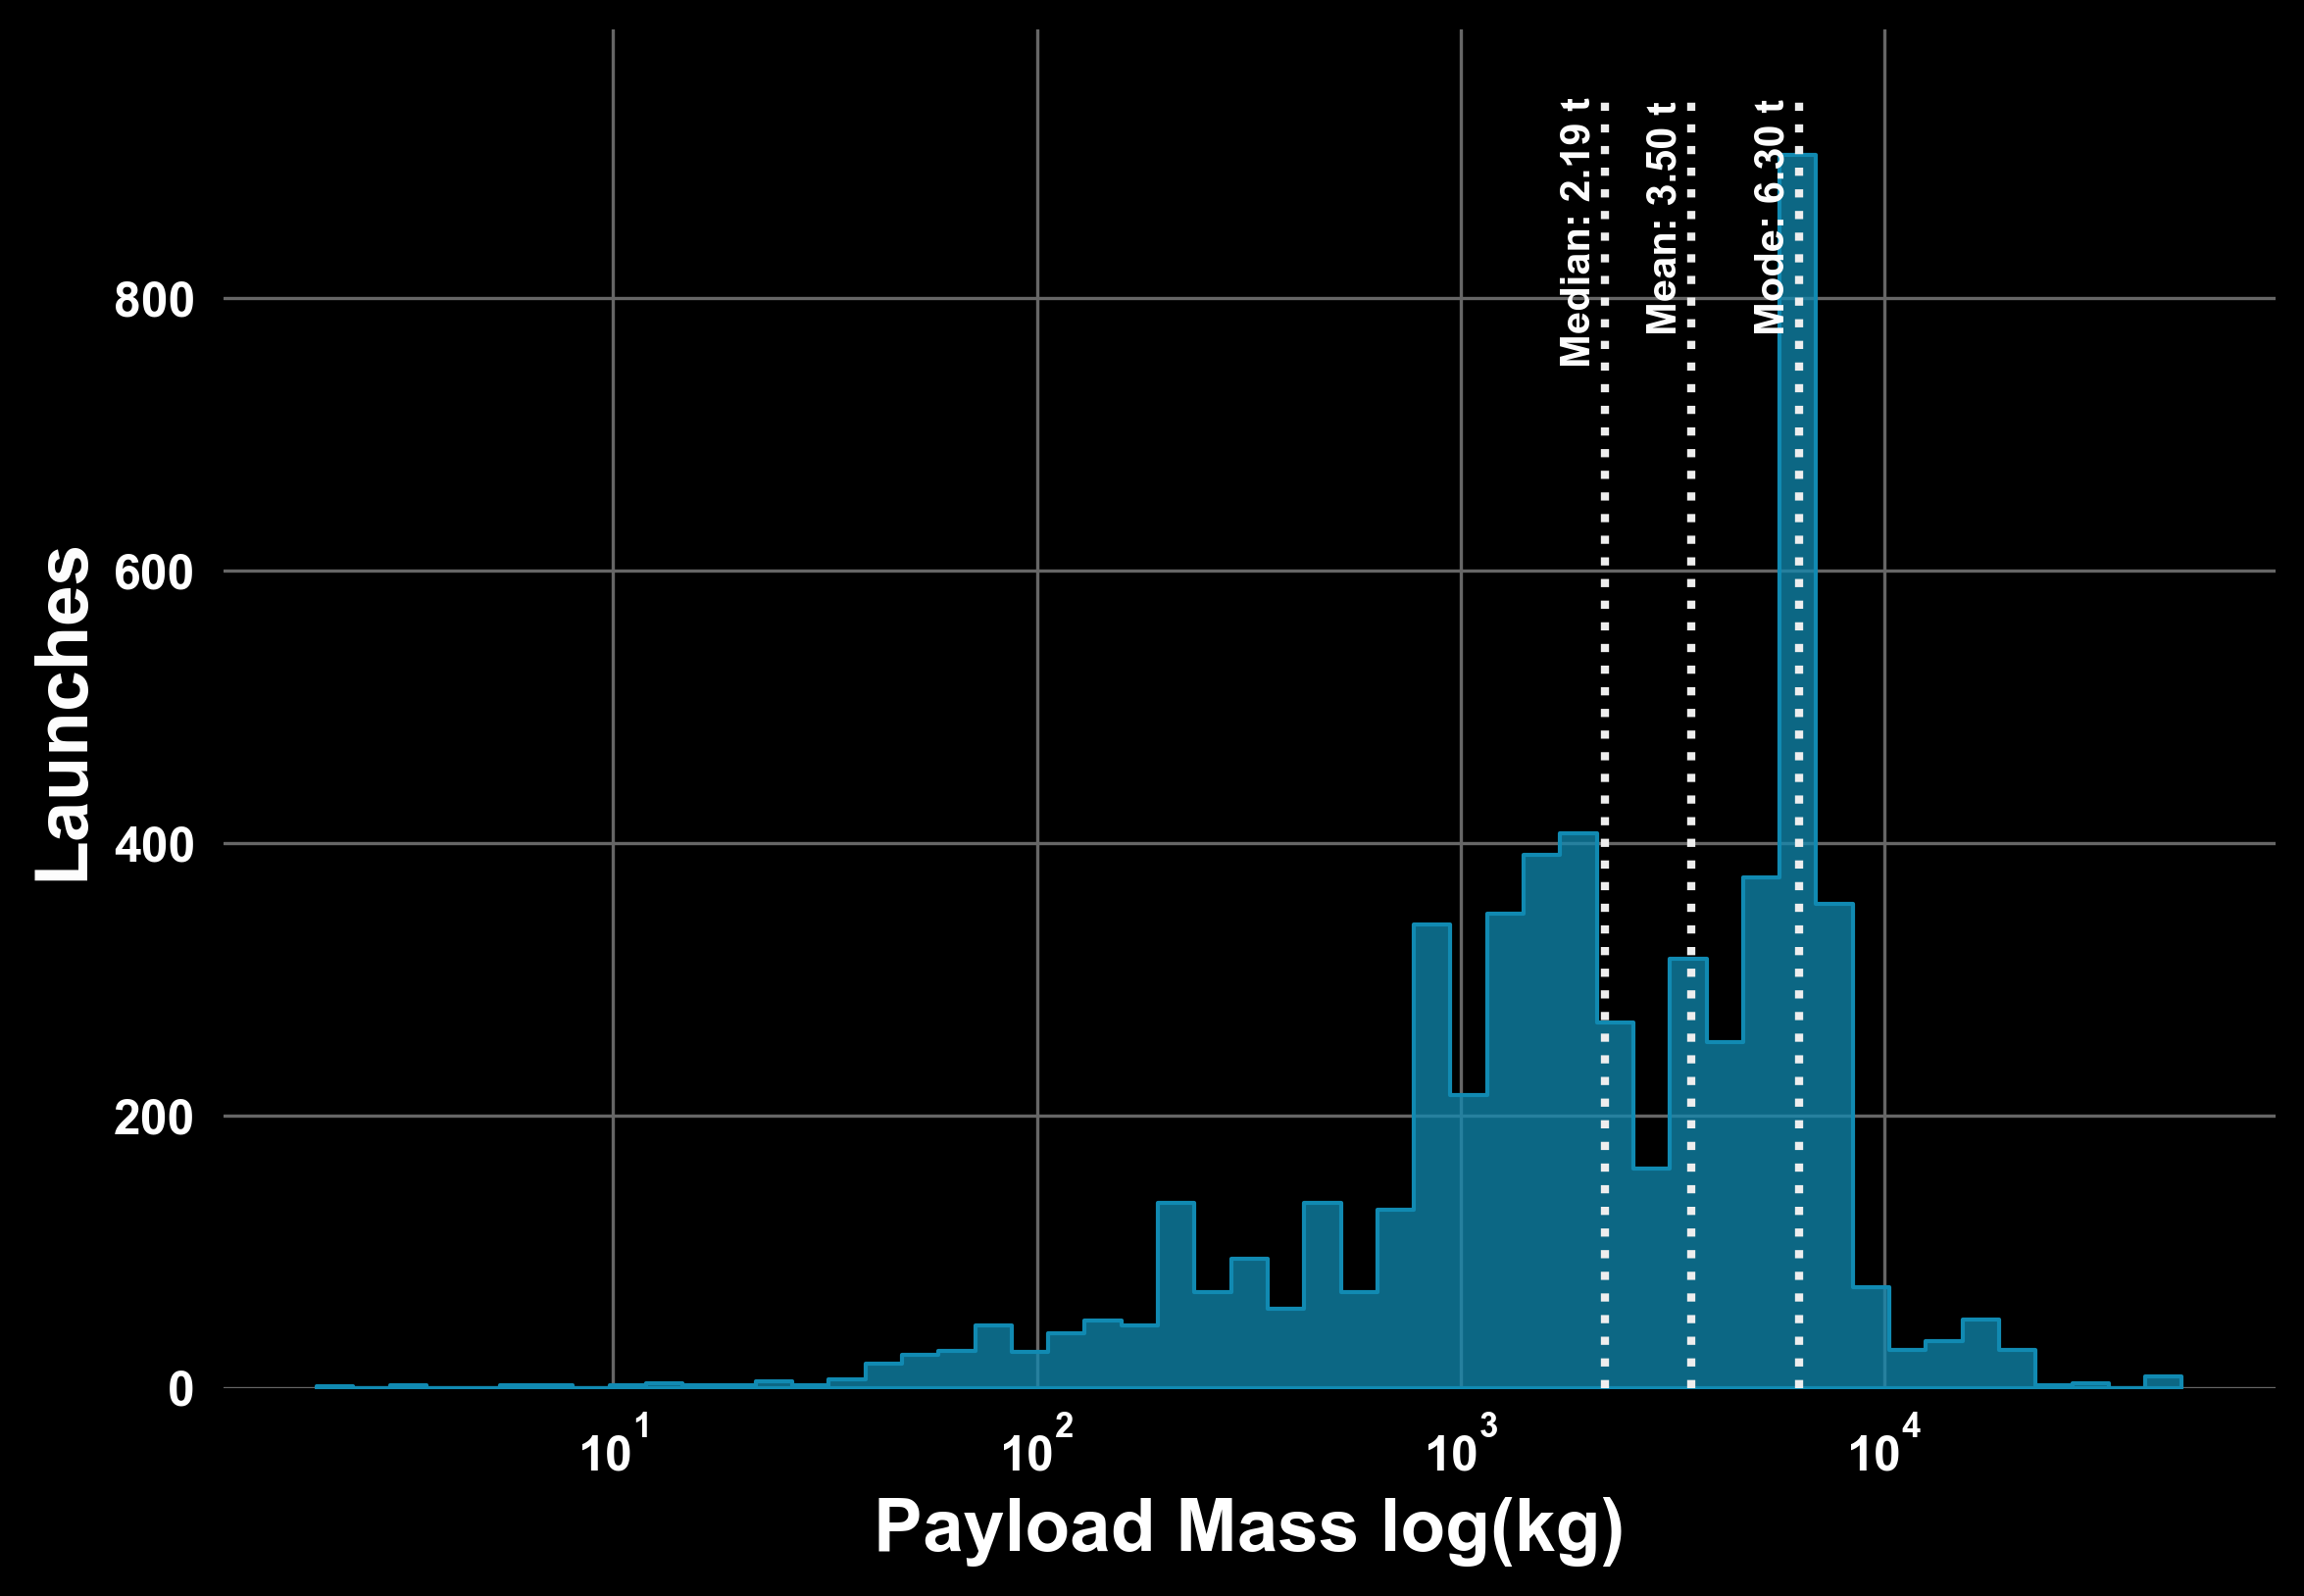

In [835]:
style()
data = pl_by_launch[pl_by_launch.TotMass < 60_000]
g = sns.histplot(
    data=data
    , x="TotMass"
    , log_scale=True
    , element="step"
    , color=colors[3]
)

med = data.TotMass.median()
avg = data.TotMass.mean()
modo = data.TotMass.mode()[0]
y = plt.gca().axes.get_ylim()
plt.plot(len(y) * [med], y,  color="#eee", linestyle="dotted", linewidth=2)
plt.plot(len(y) * [avg], y,  color="#eee", linestyle="dotted", linewidth=2)
plt.plot(len(y) * [mod], y,  color="#eee", linestyle="dotted", linewidth=2)
plt.annotate(f"Mean: {avg/1000:.2f} t", xy=(avg, y[-1]), xytext=(-11, -57)
             , rotation=90, textcoords="offset points")
plt.annotate(f"Median: {med/1000:.2f} t", xy=(med, y[-1]), xytext=(-11, -65)
             , rotation=90, textcoords="offset points")
plt.annotate(f"Mode: {modo/1000:.2f} t", xy=(modo, y[-1]), xytext=(-11, -57)
             , rotation=90, textcoords="offset points")

plt.xlabel("Payload Mass log(kg)")
plt.ylabel("Launches")

plt.show()

In [837]:
pl_by_launch[(pl_by_launch.TotMass < 60_000) & (pl_by_launch.SimpOrb(["LLEO", "LEO"]))]

TypeError: 'Series' object is not callable

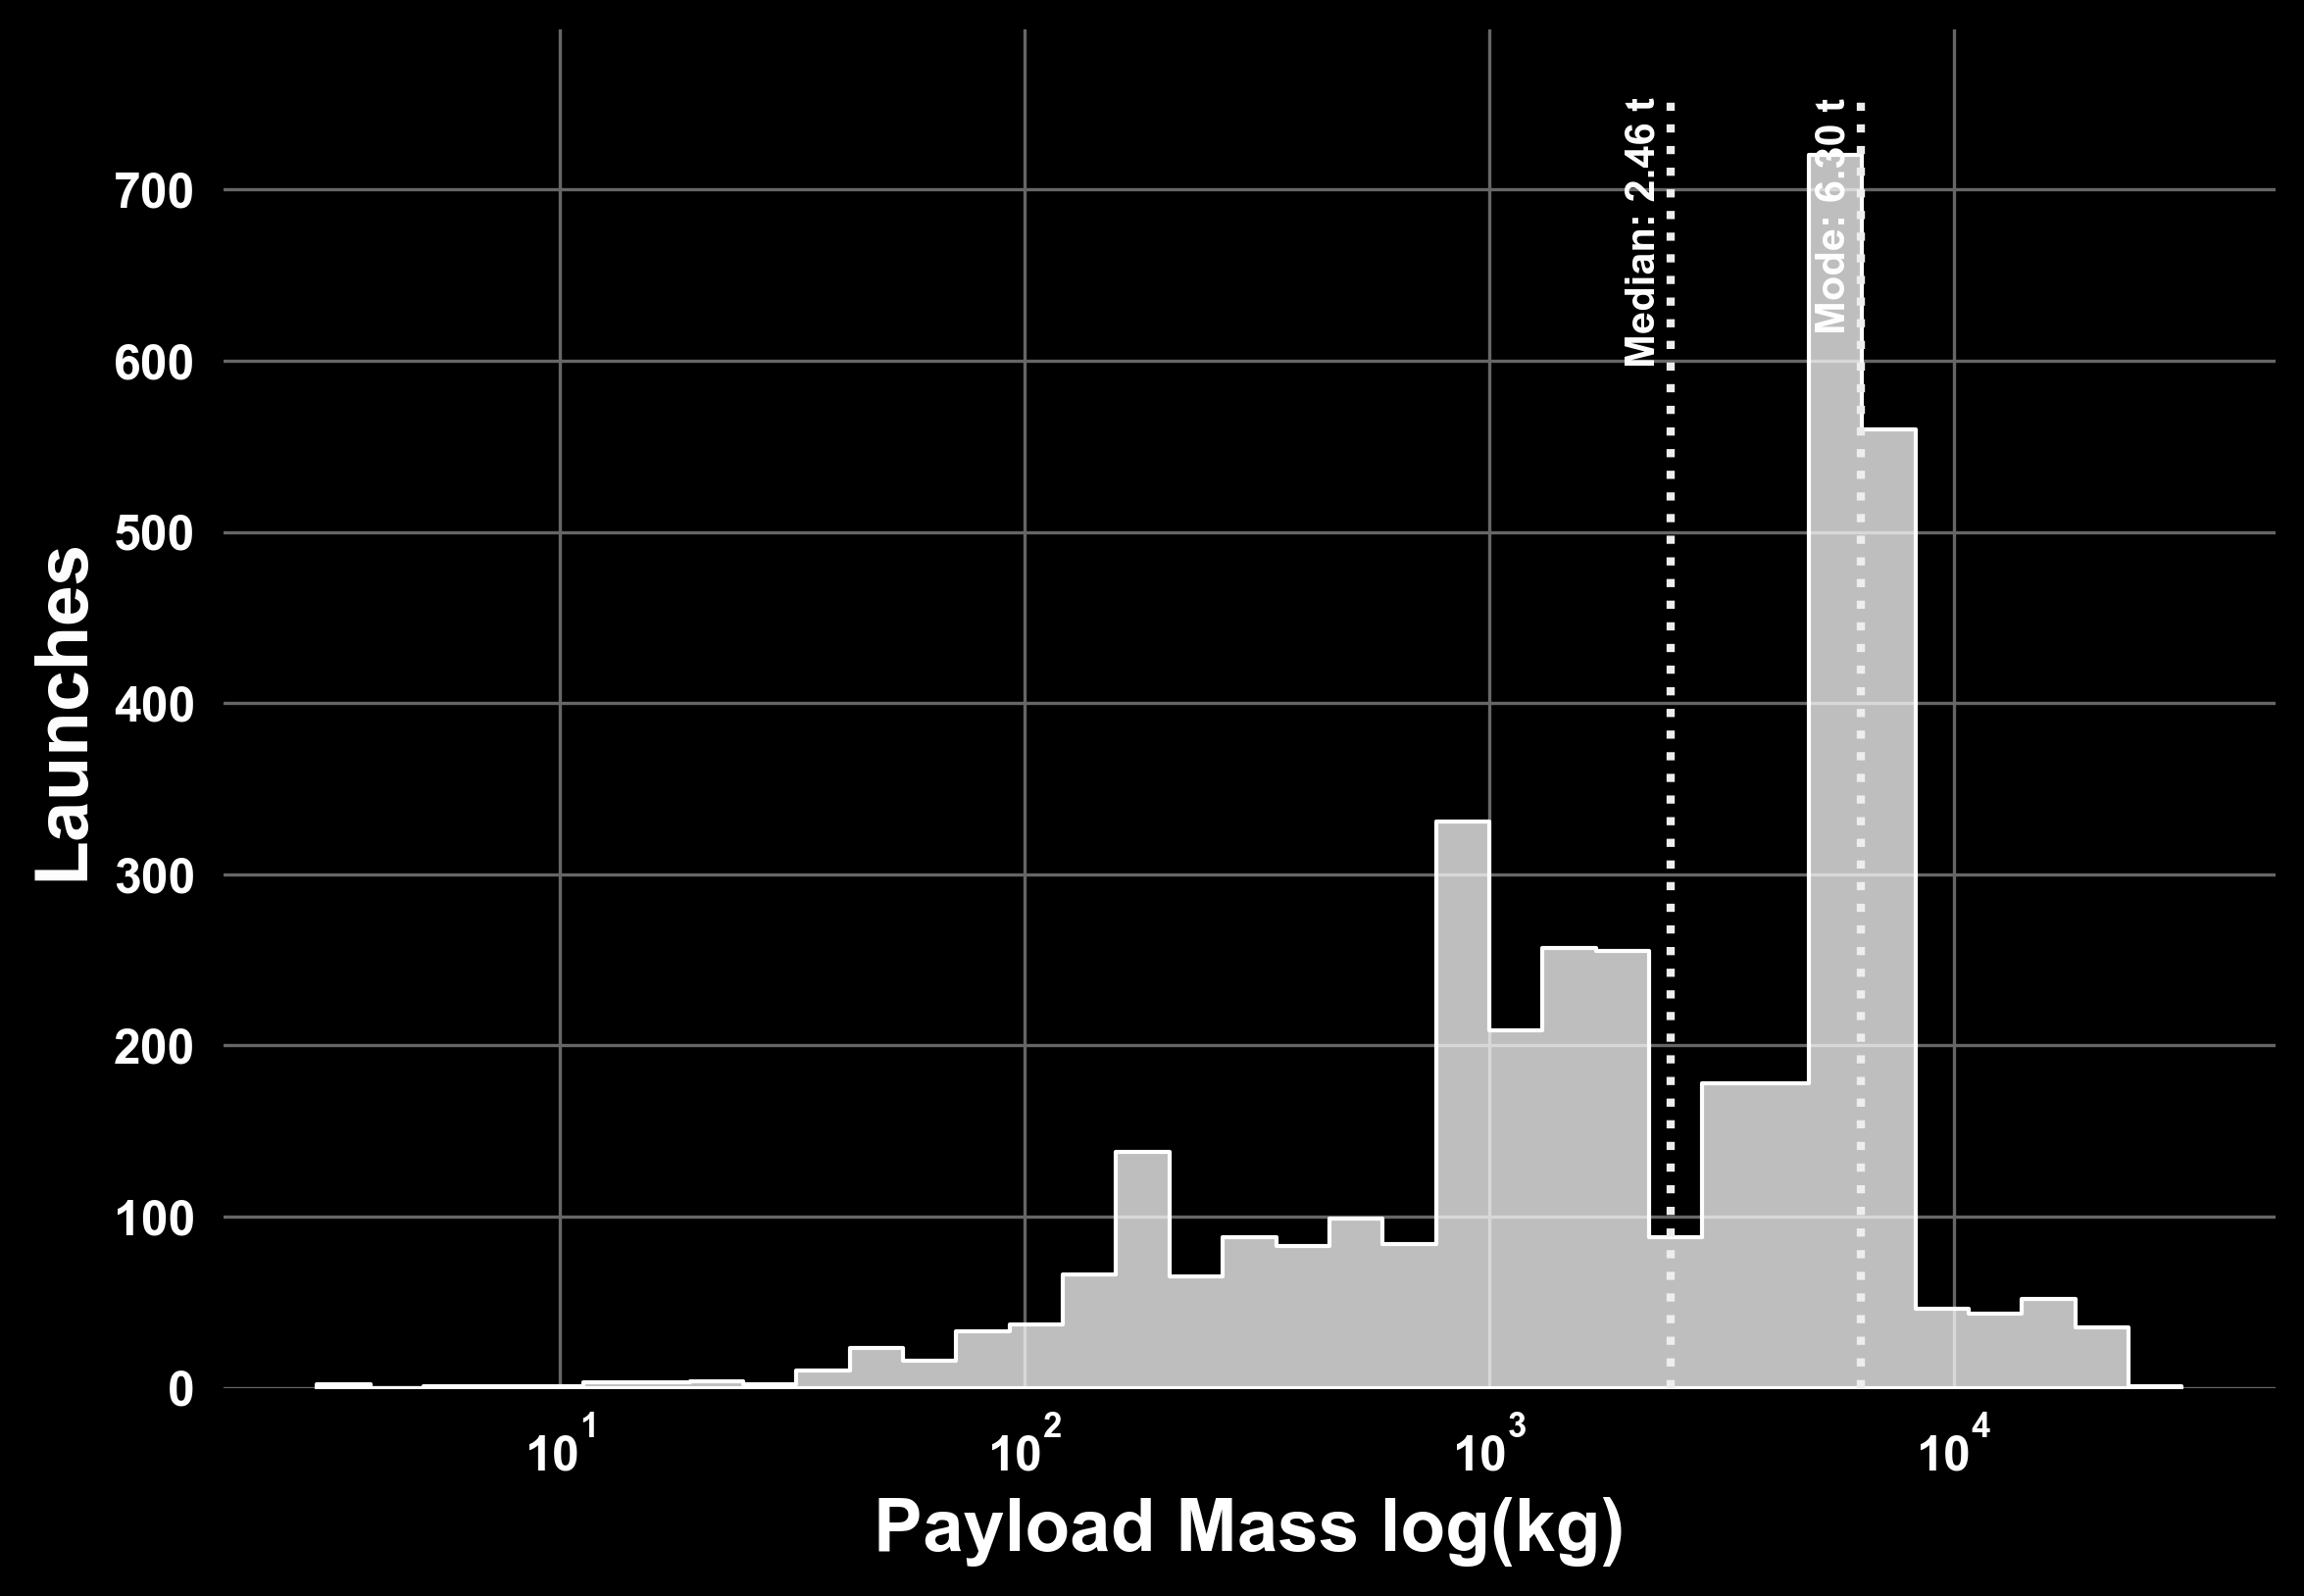

In [847]:
style()
# data = pl_by_launch[pl_by_launch.SimpOrb.isin(["LLEO", "LEO"])]
data = pl_by_launch[(pl_by_launch.TotMass < 60_000) & (pl_by_launch.SimpOrb.isin(["LLEO", "LEO"]))]
g = sns.histplot(
    data=data
    , x="TotMass"
    , log_scale=True
    , element="step"
    , color=colors[3]
)

med = data.TotMass.median()
avg = data.TotMass.mean()
modo = data.TotMass.mode()[0]
y = plt.gca().axes.get_ylim()
plt.plot(len(y) * [med], y,  color="#eee", linestyle="dotted", linewidth=2)
# plt.plot(len(y) * [avg], y,  color="#eee", linestyle="dotted", linewidth=2)
plt.plot(len(y) * [mod], y,  color="#eee", linestyle="dotted", linewidth=2)
# plt.annotate(f"Mean: {avg/1000:.2f} t", xy=(avg, y[-1]), xytext=(-11, -57)
#              , rotation=90, textcoords="offset points")
plt.annotate(f"Median: {med/1000:.2f} t", xy=(med, y[-1]), xytext=(-11, -65)
             , rotation=90, textcoords="offset points")
plt.annotate(f"Mode: {modo/1000:.2f} t", xy=(modo, y[-1]), xytext=(-11, -57)
             , rotation=90, textcoords="offset points")

plt.xlabel("Payload Mass log(kg)")
plt.ylabel("Launches")

plt.show()

In [ ]:
style()
data = pl_by_launch[pl_by_launch.TotMass < 60_000]

fig, axs = plt.subplots(5, figsize=(15,15))

for i,j in enumerate(orbit_list):
    sns.histplot(
        data=data[data.SimpOrb == j]
        , x="TotMass"
        , log_scale=True
        , element="step"
        , color=colors[3]
        , ax=axs[i]
    )

# plt.xlabel("Payload Mass log(kg)")
# plt.ylabel("Launches")

plt.show()

In [ ]:
# data = payloads[~payloads.Label.isin(["STS"])]
data = pl_by_launch[pl_by_launch.TotMass < 60_000]
# data = payloads

style()

g = sns.scatterplot(data=data
                   , x=data.set_index("LDate").index
                   , y="TotMass"
                   , hue="Label")
# g.set(yscale="log")

med = data.TotMass.median()
avg = data.TotMass.mean()
x = plt.gca().axes.get_xlim()
plt.plot(x, len(x) * [med], color="red")
plt.plot(x, len(x) * [avg], color="black")

plt.show()

In [ ]:
[(i,j) for i,j in stats.loc[orbit_list].T.loc[["+1sig", "-1sig"]].T.values]

In [ ]:
data = pl_by_launch[pl_by_launch.SimpOrb.isin(orbit_list)].SimpOrb.value_counts().reset_index()
stats = pl_by_launch[pl_by_launch.TotMass < 60_000] \
        .groupby("SimpOrb").TotMass.agg(["mean"])

label_list = [
    f"Mean PLM:\n{i/1000:.1f} t" for i in
    stats.loc[orbit_list].T.loc["mean"]
]

style()

g = sns.barplot(
    data=data
    , x="index"
    , y="SimpOrb"
    , palette=sns.color_palette([colors[3]] * 5)
)

# g.bar_label(g.containers[-1], labels=label_list, label_type='edge', fontsize=12)
plt.xlabel("")
plt.ylabel("Launches")

plt.show()

In [ ]:
stats.loc[orbit_list].iloc[1]["mean"]

In [ ]:
data = pl_by_launch[(pl_by_launch.SimpOrb.isin(orbit_list)) & (pl_by_launch.TotMass < 60_000)]
# data.TotMass = data.TotMass / 1000
# data = pl_by_launch[pl_by_launch.SimpOrb.isin(orbit_list)].SimpOrb.value_counts().reset_index()
mode_func = lambda x: x.mode()[0]
stats = pl_by_launch[pl_by_launch.TotMass < 60_000] \
        .groupby("SimpOrb").TotMass.agg(["mean", mode_func])

label_list = stats.loc[orbit_list]

style()

g = sns.stripplot(
    data=data
    , x="SimpOrb"
    , y="TotMass"
#     , palette=sns.color_palette(colors)
    , alpha=0.1
    , order=orbit_list
#     , jitter=0.2
    , color=colors[3]
)

g.set(yscale="log")

for i, j in enumerate(label_list.values):
    xmin = 0.125 + (i)*2.5 * 0.08
    xmax = xmin + 0.005
    plt.annotate(f"{j[0]/1000:.1f} t", xy=(i+0.18, j[0]/1.1), xycoords='data')
#     plt.annotate(f"{j[1]/1000:.1f} t", xy=(i-0.4, j[1]/1.1), xycoords='data')
    plt.axhline(j[0], xmin, xmax, linewidth=2)
    xmin = 0.07 + (i)*2.5 * 0.08
    xmax = xmin + 0.005
#     plt.axhline(j[1], xmin, xmax, linewidth=2)

# g.bar_label(g.containers[-1], labels=label_list, label_type='edge', fontsize=12)
# plt.xlabel("Number of Launches", labelpad=50)
plt.xlabel("")
plt.ylabel("Payload Mass log(kg)")
plt.show()

In [ ]:
# data = reusable_lv.melt(id_vars="Vehicle", value_vars=["ToLEO", "ToGTO"]).set_index("Vehicle")
data = reusable_lv.set_index("Vehicle").sort_values(by="ToLEO")

style()

g = sns.barplot(
    data=data
    , x=data.index
    , y="ToLEO"
    , hue="Status"
    , dodge=False
    , palette=sns.color_palette([colors[2], colors[0], colors[1]])
)

plt.xticks(rotation="45", ha="right")
plt.xlabel("")
plt.ylabel("Payload Capability to LEO (t)")

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

for i, j in enumerate(g.containers):
    g.bar_label(g.containers[i], fmt="%.1f t", label_type='edge', fontsize=12)
    
# for bar1, bar2, status in zip(g.containers[0], g.containers[1], reusable_lv.Status):
#     if status != "Operational":
#         bar1.set_alpha(0.5)
#         bar2.set_alpha(0.5)

plt.show()